In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DIRECTORY = '/content/drive/My Drive/Informatics/Sphere@mail.ru/1_ML/'

# Алгоритмы интеллектуальной обработки больших объемов данных
## Семинар, учимся настраивать параметры бустинга


Разберем, например, xgboost:
https://xgboost.readthedocs.io/en/latest/parameter.html

https://xgboost.readthedocs.io/en/latest/python/python_api.html

Параметры можно разделить на группы. 



1) Общие параметры алгоритма, например, тип бустинга

2) Параметры обучения бустинга, например число итераций, learning rate

3) Параметры построения деревьев, например, глубина, минимальное число элементов в листе

4) Параметры стохастики, subsample, colsample

5) Регуляриазция, например, lambda


ПРАВИЛЬНОГО алгоритма для тюнинга нет, вот один из вариантов, которые часто используют на практике.

1) Возьмите дефолтное параметры. Поставьте нужные loss и eval функции.  Измените максимальное  число деревьев, чтобы было не долго делать эксперименты

2) Подберите для него alpha, чтобы алгоритм не переобучался

3) Подберите параметры сложности дерева, например,  глубину, мин число объектов в листах, мин значение для расщепления и тд

4) Подберите паарметры стохастики

5) Подберите регуляризацию

6) Уменьшите leraning rate и обучите максимальное число деревьев, чтобы не переобучалось

Давайте настроим параметры бустинга на нашем конкурсе!

#### ЗАГРУЗКА ДАННЫХ И ФУНКЦИИ

In [3]:
import numpy as np
import pandas as pd
import time

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict

In [5]:
def get_doc_to_title():
    doc_to_title = {}
    with open(DIRECTORY + 'docs_titles.tsv') as f:
        for num_line, line in enumerate(f):
            if num_line == 0:
                continue
            data = line.strip().split('\t', 1)
            doc_id = int(data[0])
            if len(data) == 1:
                title = ''
            else:
                title = data[1]
            doc_to_title[doc_id] = title
    return doc_to_title


def get_data_titledata(doc_to_title, test=False):
    name = 'test' if test else 'train'

    data = pd.read_csv(DIRECTORY + name + '_groups.csv')
    groups_titledata = {}
    for i in range(len(data)):
        new_doc = data.iloc[i]
        doc_group = new_doc['group_id']
        doc_id = new_doc['doc_id']
        if not test:
            target = new_doc['target']
        title = doc_to_title[doc_id]
        if doc_group not in groups_titledata:
            groups_titledata[doc_group] = []
        to_append = (doc_id, title) if test else (doc_id, title, target)
        groups_titledata[doc_group].append(to_append)

    return data, groups_titledata


def get_x_y_data(test=False):
    name = 'test' if test else 'train'

    doc_to_title = get_doc_to_title()

    data, groups_titledata = get_data_titledata(doc_to_title, test)
    
    y = []
    X = []
    groups = []
    for new_group in groups_titledata:
        docs = groups_titledata[new_group]
        for k, tpl in enumerate(docs):
            if test:
                doc_id, title = tpl
            else:
                doc_id, title, target_id = tpl
                y.append(target_id)
            groups.append(new_group)
            all_dist = []
            words = set(title.strip().split())
            for j in range(0, len(docs)):
                if k == j:
                    continue
                if test:
                    doc_id_j, title_j = docs[j]
                else:
                    doc_id_j, title_j, target_j = docs[j]
                words_j = set(title_j.strip().split())
                all_dist.append(len(words.intersection(words_j)))
            X.append(sorted(all_dist, reverse=True)[0:25])
    X = np.array(X)
    y = np.array(y)
    groups = np.array(groups)
    print (X.shape, y.shape, groups.shape)
    return X, y, groups, data

In [6]:
from sklearn.metrics import f1_score

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1 - f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [7]:
def cross_validate(model, fit_params=None):
    return cross_val_score(model, X_train, y_train, cv=3,
                           groups=groups_train, scoring='f1',
                           fit_params=fit_params).mean()

In [9]:
from itertools import product
from tqdm.notebook import tqdm
from copy import deepcopy

In [10]:
def search_parametrs(clf, parametrs, X_train, y_train, fit_params=None, print_scores=False):
    best_model = None
    best_score = 0
    best_params = None
    model = deepcopy(clf)
    keys = parametrs.keys()
    for cur_param in tqdm(list(product(*parametrs.values()))):
        params_to_set = dict()
        for i, key in enumerate(keys):
            params_to_set[key] = cur_param[i]
        model.set_params(**params_to_set)
        try:
            score = cross_validate(model, fit_params=fit_params)
        except Exception:
            continue
        if print_scores:
            print(f'{str(params_to_set)} - SCORE: {score}')
        if score > best_score:
            best_score = score
            best_model = deepcopy(model)
            best_params = params_to_set
    print(best_params)
    print('F1-Score: ', best_score)
    print(best_model)
    return best_model

In [34]:
def make_precision(model, X_test, test_data, to_drive=False, y_test=None):
    if y_test is None:
        y_test = np.asarray(model.predict(X_test))
    y_test = y_test.reshape((-1))
    y_test = np.asarray(y_test, dtype=np.int64)
    assert y_test.shape[0] == X_test.shape[0]
    test_data["target"] = pd.Series(y_test)
    name = str(time.time()) + "_predict.csv"
    if to_drive:
        name = DIRECTORY + 'predictions/' + name
    with open(name, "w") as f:
        f.write(test_data.to_csv(columns=("pair_id", "target"), index=False))

    print(name)
    print(model)

    return y_test

In [20]:
X_train, y_train, groups_train, train_data = get_x_y_data()
X_test, y_test, groups_test, test_data = get_x_y_data(test=True)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(11690, 25) (11690,) (11690,)
(16627, 25) (0,) (16627,)


#### Работа

Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [21]:
import matplotlib.pyplot as plt

In [22]:
#import lightgbm as lgb
import xgboost as xgb
#from sklearn.ensemble import GradientBoostingClassifier
clf = xgb.XGBClassifier(random_state=77)
#clf = lgb.LGBMClassifier()

In [23]:
fit_params = {
    'eval_set': [(X_train, y_train)], 
    'eval_metric': f1_eval,
    'verbose': False
}

In [ ]:
%%time

clf = xgb.XGBClassifier(random_state=77, n_estimators=25, objective='binary:logistic', eval_metric='rmse')
clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], eval_metric=f1_eval, verbose=False)

CPU times: user 459 ms, sys: 999 µs, total: 460 ms
Wall time: 464 ms


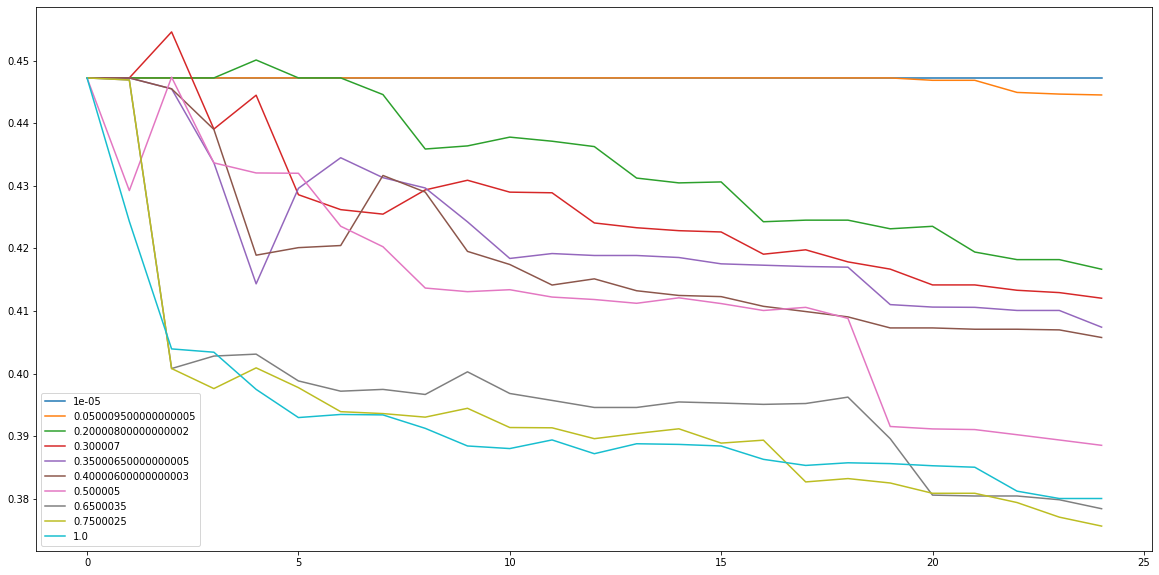

In [ ]:
plt.figure(figsize=(20,10))
for lr in np.linspace(1e-5, 1, 21):
    clf.learning_rate = lr
    clf.fit(X_train, y_train, **fit_params)
    res = clf.evals_result()['validation_0']['f1_err']
    if res[-1] == min(res):
        plt.plot(clf.evals_result()['validation_0']['f1_err'], label=lr)

plt.legend()
plt.show()

In [ ]:
clf.learning_rate = 0.75

In [ ]:
# parametrs = {
#     'learning_rate': np.linspace(1e-7, 1, 50),
# }

# clf = search_parametrs(clf, parametrs, X_train, y_train, fit_params=fit_params, print_scores=True)

In [ ]:
%%time

parametrs = {
    'min_split_loss': np.linspace(0, 100, 5),
    'max_depth': np.linspace(1, 15, 6, dtype=int),
    'min_child_weight': np.linspace(0, 100, 5),
    'sampling_method': ['uniform', 'gradient_based'],
    'scale_pos_weight': np.linspace(2, 3, 5),
}

clf = search_parametrs(clf, parametrs, X_train, y_train, fit_params=fit_params)


{'min_split_loss': 25.0, 'max_depth': 6, 'min_child_weight': 100.0, 'sampling_method': 'uniform', 'scale_pos_weight': 2.25}
F1-Score:  0.6360854528940073
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
              gamma=0, learning_rate=0.75, max_delta_step=0, max_depth=6,
              min_child_weight=100.0, min_split_loss=25.0, missing=None,
              n_estimators=25, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=77, reg_alpha=0,
              reg_lambda=1, sampling_method='uniform', scale_pos_weight=2.25,
              seed=None, silent=None, subsample=1, verbosity=1)
CPU times: user 39min 54s, sys: 7.14 s, total: 40min 1s
Wall time: 40min 5s


In [ ]:
%%time

parametrs = {
    'scale_pos_weight': np.linspace(2.2, 2.3, 21),
}

clf = search_parametrs(clf, parametrs, X_train, y_train, fit_params=fit_params, print_scores=True)

{'scale_pos_weight': 2.2} - SCORE: 0.6325399880753783
{'scale_pos_weight': 2.205} - SCORE: 0.6325399880753783
{'scale_pos_weight': 2.21} - SCORE: 0.6327366489008575
{'scale_pos_weight': 2.2150000000000003} - SCORE: 0.6327366489008575
{'scale_pos_weight': 2.22} - SCORE: 0.6327366489008575
{'scale_pos_weight': 2.225} - SCORE: 0.6327366489008575
{'scale_pos_weight': 2.23} - SCORE: 0.6360854528940073
{'scale_pos_weight': 2.235} - SCORE: 0.6360854528940073
{'scale_pos_weight': 2.24} - SCORE: 0.6360854528940073
{'scale_pos_weight': 2.245} - SCORE: 0.6360854528940073
{'scale_pos_weight': 2.25} - SCORE: 0.6360854528940073
{'scale_pos_weight': 2.255} - SCORE: 0.6352703397371219
{'scale_pos_weight': 2.26} - SCORE: 0.6352703397371219
{'scale_pos_weight': 2.265} - SCORE: 0.6352703397371219
{'scale_pos_weight': 2.27} - SCORE: 0.6352703397371219
{'scale_pos_weight': 2.275} - SCORE: 0.6352703397371219
{'scale_pos_weight': 2.28} - SCORE: 0.6352703397371219
{'scale_pos_weight': 2.2849999999999997} - SC

In [ ]:
%%time

parametrs = {
    'subsample': np.linspace(1e-10, 1, 101),
}

clf = search_parametrs(clf, parametrs, X_train, y_train, fit_params=fit_params)


{'subsample': 0.940000000006}
F1-Score:  0.6395916707679302
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
              gamma=0, learning_rate=0.75, max_delta_step=0, max_depth=6,
              min_child_weight=100.0, min_split_loss=25.0, missing=None,
              n_estimators=25, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=77, reg_alpha=0,
              reg_lambda=1, sampling_method='uniform', scale_pos_weight=2.23,
              seed=None, silent=None, subsample=0.940000000006, verbosity=1)
CPU times: user 2min 15s, sys: 455 ms, total: 2min 15s
Wall time: 2min 16s


In [ ]:
%%time

parametrs = {
    'subsample': np.linspace(0.9385, 0.9405, 21),
}

clf = search_parametrs(clf, parametrs, X_train, y_train, fit_params=fit_params, print_scores=True)

{'subsample': 0.9385} - SCORE: 0.639517684724933
{'subsample': 0.9386} - SCORE: 0.6395919777406939
{'subsample': 0.9387} - SCORE: 0.6395919777406939
{'subsample': 0.9388} - SCORE: 0.6395919777406939
{'subsample': 0.9389} - SCORE: 0.6395919777406939
{'subsample': 0.9390000000000001} - SCORE: 0.6395919777406939
{'subsample': 0.9391} - SCORE: 0.6395919777406939
{'subsample': 0.9392} - SCORE: 0.6395919777406939
{'subsample': 0.9393} - SCORE: 0.6395919777406939
{'subsample': 0.9394} - SCORE: 0.6395916707679302
{'subsample': 0.9395} - SCORE: 0.639764751532753
{'subsample': 0.9396} - SCORE: 0.639764751532753
{'subsample': 0.9397} - SCORE: 0.639764751532753
{'subsample': 0.9398} - SCORE: 0.639764751532753
{'subsample': 0.9399} - SCORE: 0.639764751532753
{'subsample': 0.94} - SCORE: 0.6395916707679302
{'subsample': 0.9401} - SCORE: 0.6395916707679302
{'subsample': 0.9402} - SCORE: 0.6395916707679302
{'subsample': 0.9403} - SCORE: 0.639517684724933
{'subsample': 0.9404} - SCORE: 0.63774741851697

In [ ]:
%%time

parametrs = {
    'reg_lambda': np.linspace(0, 10, 11),
    'reg_alpha': np.linspace(0, 10, 11),
}

clf = search_parametrs(clf, parametrs, X_train, y_train, fit_params=fit_params, print_scores=False)


{'reg_lambda': 0.0, 'reg_alpha': 0.0}
F1-Score:  0.639764751532753
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
              gamma=0, learning_rate=0.75, max_delta_step=0, max_depth=6,
              min_child_weight=100.0, min_split_loss=25.0, missing=None,
              n_estimators=25, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=77, reg_alpha=0.0,
              reg_lambda=0.0, sampling_method='uniform', scale_pos_weight=2.23,
              seed=None, silent=None, subsample=0.9395, verbosity=1)
CPU times: user 2min 54s, sys: 516 ms, total: 2min 55s
Wall time: 2min 55s


In [ ]:
cur_lr = clf.learning_rate
cur_lr

0.75

In [36]:
# %%time
# for est in tqdm([25, 50, 100, 200, 300, 400, 500]):
#     plt.figure(figsize=(20,10))
#     for lr in tqdm(np.linspace(1e-5, cur_lr, 10)):
#         clf.learning_rate = lr
#         clf.n_estimators = est
#         clf.fit(X_train, y_train, **fit_params)
#         res = clf.evals_result()['validation_0']['f1_err']
#         if res[-1] == min(res):
#             plt.plot(clf.evals_result()['validation_0']['f1_err'], label=lr)

#     plt.title(est)
#     plt.legend()
#     plt.show()

In [ ]:
parametrs = {
    'learning_rate': np.linspace(1e-7, cur_lr, 5),
    'n_estimators': [25, 50, 100, 200, 300, 400, 500]
}

clf = search_parametrs(clf, parametrs, X_train, y_train, fit_params=fit_params, print_scores=True)

#### Precision

Задача: обучите на этих фичах (число фичей рассатриваем как гипераматр) бустинг, подберите параметры, засабмитьте на кагл. Побейте 0.62 паблик скор за сутки.  Удачи!

In [26]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
              gamma=0.0, learning_rate=0.5, max_delta_step=0, max_depth=1,
              max_leaves=0, min_child_weight=100.0, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=77, reg_alpha=0.5,
              reg_lambda=0.5, sampling_method='uniform',
              scale_pos_weight=2.4725, seed=None, silent=None, subsample=0.6295,
              tree_method='auto', verbosity=1)

In [35]:
y = make_precision(clf, X_test, test_data)

1606842975.7948892_predict.csv
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
              gamma=0.0, learning_rate=0.5, max_delta_step=0, max_depth=1,
              max_leaves=0, min_child_weight=100.0, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=77, reg_alpha=0.5,
              reg_lambda=0.5, sampling_method='uniform',
              scale_pos_weight=2.4725, seed=None, silent=None, subsample=0.6295,
              tree_method='auto', verbosity=1)
